In [1]:
import ROOT
import matplotlib.pyplot as plt
import numpy as np

Welcome to JupyROOT 6.24/06


In [29]:
ROOT.ROOT.DisableImplicitMT()

Warning in <ROOT_TImplicitMT_DisableImplicitMT>: Implicit multi-threading is already disabled


In [30]:
path = "../merged/file1*.root"

In [31]:
data = ROOT.RDataFrame("rootuple/CandidateTree", path)

In [46]:
cut = data.Filter("candidate_charge == 0")\
          .Filter("candidate_cosAlpha > 0.99")\
          .Filter("candidate_vProb > 0.05")\
          .Filter("candidate_lxy / candidate_lxyErr > 3.0")\
          .Filter("ditrack_mass > 1.014")\
          .Filter("ditrack_mass < 1.024")\
          .Filter("candidate_vMass > 5.33")\
          .Filter("candidate_vMass < 5.40")

In [48]:
a = cut.Range(0, 0, 100)
b = cut.Range(1, 0, 100)

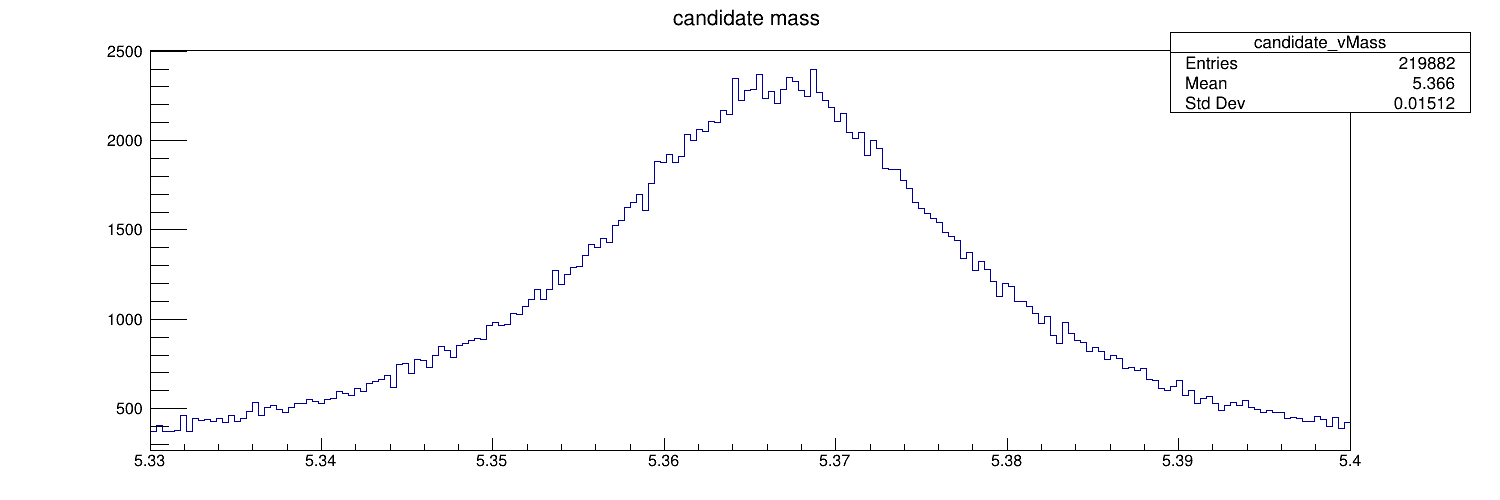

In [244]:
hist1 = cut.Histo1D(("candidate_vMass", "candidate mass", 200, 5.33, 5.40), "candidate_vMass")
canvas1 = ROOT.TCanvas()
canvas1.SetCanvasSize(1500, 500)
hist1.Draw()
canvas1.Draw()

In [29]:
# hist2 = cut.Histo1D(("ditrack_mass", "ditrack mass", 200, 1.014, 1.024), "ditrack_mass")
# canvas2 = ROOT.TCanvas()
# canvas2.SetCanvasSize(1500, 500)
# hist2.Draw()
# canvas2.Draw()

In [31]:
import goofit as gf

In [32]:
data = cut.AsNumpy(["candidate_vMass"])

In [38]:
data

{'candidate_vMass': ndarray([5.33761597, 5.38097239, 5.36739302, ..., 5.38571501, 5.36440229,
          5.37167645])}

In [230]:
x = gf.Observable('x', 5.33, 5.4)

mean = gf.Variable('mu', 5.37, 5.33, 5.4)
sig_1 = gf.Variable('sigma_1', 0.01, 0.001, 0.015)

f_0 = gf.Variable('f_0', 0.5, 0, 1)

In [231]:
gauss_1 = gf.GaussianPdf("gauss1", x, mean, sig_1)

pdf = gf.AddPdf('pdf', [f_0], [gauss_1])

In [232]:
ds = gf.UnbinnedDataSet(x)
ds.from_matrix([data["candidate_vMass"]], filter=True)

In [233]:
pdf.fitTo(ds)

MnSeedGenerator: for initial parameters FCN = -669184.6743937
MnSeedGenerator: Initial state:   - FCN =  -669184.6743937 Edm =       280444 NCalls =     13
VariableMetric: start iterating until Edm is < 0.0001
VariableMetric: Initial state   - FCN =  -669184.6743937 Edm =       280444 NCalls =     13
VariableMetric: Iteration #   0 - FCN =  -669184.6743937 Edm =       280444 NCalls =     13
VariableMetric: Iteration #   1 - FCN =  -1033998.194075 Edm =      5771.64 NCalls =     25
VariableMetric: Iteration #   2 - FCN =  -1045599.987537 Edm =      733.978 NCalls =     34
VariableMetric: Iteration #   3 - FCN =  -1051069.338868 Edm =      296.964 NCalls =     47
VariableMetric: Iteration #   4 - FCN =  -1051632.826624 Edm =      50.4866 NCalls =     55
VariableMetric: Iteration #   5 - FCN =  -1051838.675717 Edm =       14.399 NCalls =     68
VariableMetric: Iteration #   6 - FCN =  -1051863.219684 Edm =      2.50524 NCalls =     76
VariableMetric: Iteration #   7 - FCN =  -1051868.9457

In [234]:
x.numbins = 1000
grid, points = pdf.evaluatePdf(x)
xs = grid.to_matrix().flatten()

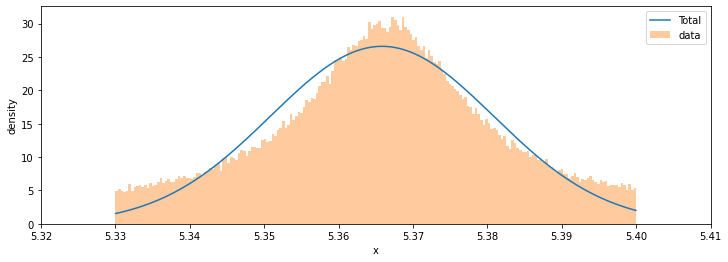

In [235]:
fig, ax = plt.subplots(figsize=(12,4))
ax.plot(xs, points, label='Total')
ax.hist(data["candidate_vMass"], bins=200, density=True, alpha=.4, label='data')
ax.set_xlim(5.32, 5.41)
ax.set_xlabel('x')
ax.set_ylabel('density')
plt.legend()
plt.show()